<a href="https://colab.research.google.com/github/ArthurChan-1111/Bitcoin_prediction/blob/main/Master_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install pandas_ta
!pip install numpy==1.23.5
!pip install pandas

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/index_command.py", line 71, in get_default_session
    self._session = self.enter_context(self._build_session(options))
                                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/index_command.py", line 100, in _build_session
    session = PipSession(
              ^^^^^^^^^

In [94]:
!git clone https://github.com/ArthurChan-1111/Bitcoin_prediction.git

%cd Bitcoin_prediction

import pandas as pd
import pandas_ta as ta
import csv
import numpy as np

btc_data = pd.read_csv('Bitcoin Historical Data.csv', on_bad_lines='skip', lineterminator='\n')
btc_data.tail(5)

Cloning into 'Bitcoin_prediction'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 134 (delta 9), reused 0 (delta 0), pack-reused 119 (from 1)
Receiving objects: 100% (134/134), 8.34 MiB | 16.46 MiB/s, done.
Resolving deltas: 100% (52/52), done.
/content/Bitcoin_prediction/Bitcoin_prediction/Bitcoin_prediction/Bitcoin_prediction/Bitcoin_prediction/Bitcoin_prediction/Bitcoin_prediction


,Date,Price,Open,High,Low,Vol. ('000),Change %\r
4107,1/5/2014,1014.7,924.7,1029.9,911.4,21.37,9.74%\r
4108,1/4/2014,924.7,884.3,932.2,848.3,14.24,4.57%\r
4109,1/3/2014,884.3,856.9,888.2,839.4,9.71,3.19%\r
4110,1/2/2014,856.9,815.9,886.2,810.5,12.81,5.02%\r
4111,1/1/2014,815.9,805.9,829.9,771.0,10.76,1.24%


In [95]:
# Convert the dictionary to a DataFrame
btc_data = pd.DataFrame(btc_data)

# 1. Parse the "Date" column into datetime format
btc_data["Date"] = pd.to_datetime(btc_data["Date"], format="%m/%d/%Y")

# 2. Sort the data by date in ascending order
btc_data.sort_values(by="Date", ascending=True, inplace=True)

#3. Function to clean and convert volume data
def clean_volume(volume):
    if isinstance(volume, str):  # Check if the value is a string
        volume = volume.replace(',', '')  # Remove commas
        if 'B' in volume:  # If the value contains 'B' (billions)
            return float(volume.replace('B', '')) * 1_000_000_000
        elif 'M' in volume:  # If the value contains 'M' (millions)
            return float(volume.replace('M', '')) * 1_000_000
        elif 'K' in volume:  # If the value contains 'K' (thousands)
            return float(volume.replace('K', '')) * 1_000
        else:  # If no suffix is present, convert to float directly
            return float(volume)
    return np.nan  # Handle unexpected cases

# Apply the cleaning function to the volume column
btc_data["Volume"] = btc_data["Vol. ('000)"].apply(clean_volume)
btc_data = btc_data.drop("Vol. ('000)", axis=1)

# 4. Remove '%' from "Change %" and convert to numeric
btc_data.rename(columns={"Change %\r": "Change"}, inplace=True)
btc_data["Change"] = btc_data["Change"].str.replace("%", "").str.strip().astype(float)

In [96]:
# Day of the week (0=Monday, 6=Sunday)
btc_data["Day_of_Week"] = btc_data["Date"].dt.dayofweek

# Week of the year
btc_data["Week_of_Year"] = btc_data["Date"].dt.isocalendar().week

# Month of the year
btc_data["Month"] = btc_data["Date"].dt.month

# Quarter of the year
btc_data["Quarter"] = btc_data["Date"].dt.quarter

# Year
btc_data["Year"] = btc_data["Date"].dt.year

In [97]:
# Calculate RSI, EMA, SMA, and MACD
btc_data["RSI_6"] = ta.rsi(btc_data["Price"], length=6)  # Relative Strength Index
btc_data["RSI_12"] = ta.rsi(btc_data["Price"], length=12)  # Relative Strength Index
btc_data["EMA_14"] = ta.ema(btc_data["Price"], length=14)  # Exponential Moving Average
btc_data["SMA_14"] = ta.sma(btc_data["Price"], length=14)  # Simple Moving Average

# Add On-Balance Volume (OBV)
btc_data["OBV"] = ta.obv(btc_data["Price"], btc_data["Volume"])

# Calculate MACD --------------------------------------------------------------------------------------
macd = ta.macd(btc_data["Price"], fast=12, slow=26, signal=9)
btc_data["MACD"] = macd["MACD_12_26_9"]
btc_data["MACD_Signal"] = macd["MACDs_12_26_9"]
btc_data["MACD_Hist"] = macd["MACDh_12_26_9"]

# Create MACD_buy: 1 if MACD crosses above MACD_Signal, otherwise 0
btc_data["MACD_buy"] = 0  # Default to 0 (no buy signal)
btc_data.loc[
    (btc_data["MACD"] > btc_data["MACD_Signal"]) &  # MACD is above Signal
    (btc_data["MACD"].shift(1) <= btc_data["MACD_Signal"].shift(1)),  # Previous MACD was below or equal to Signal
    "MACD_buy"] = 1  # Buy signal

# Create MACD_sell: 1 if MACD crosses below MACD_Signal, otherwise 0
btc_data["MACD_sell"] = 0  # Default to 0 (no sell signal)
btc_data.loc[
    (btc_data["MACD"] <= btc_data["MACD_Signal"]) &  # MACD is below or equal to Signal
    (btc_data["MACD"].shift(1) > btc_data["MACD_Signal"].shift(1)),  # Previous MACD was above Signal
    "MACD_sell"] = 1  # Sell signal

# Calculate Bollinger Bands --------------------------------------------------------------------------------------
bbands = ta.bbands(btc_data["Price"], length=20, std=2)
btc_data["BB_Lower"] = bbands["BBL_20_2.0"]  # Lower Band
btc_data["BB_Middle"] = bbands["BBM_20_2.0"]  # Middle Band
btc_data["BB_Upper"] = bbands["BBU_20_2.0"]  # Upper Band

# Create BB_Buy: 1 if Price crosses below the Lower Band, otherwise 0
btc_data["BB_Buy"] = 0  # Default to 0 (no buy signal)
btc_data.loc[
    (btc_data["Price"] < btc_data["BB_Lower"]) &  # Price is below the Lower Band
    (btc_data["Price"].shift(1) >= btc_data["BB_Lower"].shift(1)),  # Previous Price was above or equal to Lower Band
    "BB_Buy"] = 1  # Buy signal

# Create BB_Sell: 1 if Price crosses above the Upper Band, otherwise 0
btc_data["BB_Sell"] = 0  # Default to 0 (no sell signal)
btc_data.loc[
    (btc_data["Price"] > btc_data["BB_Upper"]) &  # Price is above the Upper Band
    (btc_data["Price"].shift(1) <= btc_data["BB_Upper"].shift(1)),  # Previous Price was below or equal to Upper Band
    "BB_Sell"] = 1  # Sell signal

# Calculate ATR --------------------------------------------------------------------------------------
btc_data["ATR"] = ta.atr(btc_data["High"], btc_data["Low"], btc_data["Price"], length=14)

# Set Stop-Loss Levels (Example with Long Trade)
atr_multiplier = 2
btc_data["Stop_Loss_Long"] = btc_data["Price"] - (btc_data["ATR"] * atr_multiplier) #Stop-Loss for Buy (Long) Trade
btc_data["Stop_Loss_Short"] = btc_data["Price"] + (btc_data["ATR"] * atr_multiplier) #Stop-Loss for Sell (Short) Trade

# Calculate VWAP --------------------------------------------------------------------------------------
btc_data.set_index("Date", inplace=True) # Set the "Date" column as the index
btc_data["VWAP"] = ta.vwap(btc_data["High"], btc_data["Low"], btc_data["Price"], btc_data["Volume"])

# Create VWAP_Buy: 1 if Price crosses above VWAP, otherwise 0
btc_data["VWAP_Buy"] = 0  # Default to 0 (no buy signal)
btc_data.loc[
    (btc_data["Price"] > btc_data["VWAP"]) &  # Price is above VWAP
    (btc_data["Price"].shift(1) <= btc_data["VWAP"].shift(1)),  # Previous Price was below or equal to VWAP
    "VWAP_Buy"] = 1  # Buy signal

# Create VWAP_Sell: 1 if Price crosses below VWAP, otherwise 0
btc_data["VWAP_Sell"] = 0  # Default to 0 (no sell signal)
btc_data.loc[
    (btc_data["Price"] < btc_data["VWAP"]) &  # Price is below VWAP
    (btc_data["Price"].shift(1) >= btc_data["VWAP"].shift(1)),  # Previous Price was above or equal to VWAP
    "VWAP_Sell"] = 1  # Sell signal

# Display the first few rows of the data with calculated indicators
btc_data.tail(20)

,Price,Open,High,Low,Change,Volume,Day_of_Week,Week_of_Year,Month,Quarter,...,BB_Middle,BB_Upper,BB_Buy,BB_Sell,ATR,Stop_Loss_Long,Stop_Loss_Short,VWAP,VWAP_Buy,VWAP_Sell
Date,,,,,,,,,,,,,,,,,,,,,
2025-03-17,84019.1,82580.3,84729.2,82525.0,1.74,58.04,0,12,3,1,...,85114.295,92092.943188,0,0,4302.423779,75414.252443,92623.947557,83757.766667,1,0
2025-03-18,82719.1,84019.1,84019.1,81171.3,-1.55,58.17,1,12,3,1,...,85039.615,92086.886758,0,0,4198.522080,74322.055840,91116.144160,82636.500000,0,0
2025-03-19,86841.0,82719.1,86990.6,82557.5,4.98,84.61,2,12,3,1,...,85145.935,92234.425255,0,0,4215.277646,78410.444708,95271.555292,85463.033333,0,0
2025-03-20,84208.1,86841.3,87419.0,83656.1,-3.03,69.86,3,12,3,1,...,85137.280,92229.905566,0,0,4182.964957,75842.170086,92574.029914,85094.400000,0,1
2025-03-21,84073.3,84208.7,84831.0,83215.9,-0.16,42.80,4,12,3,1,...,85037.365,92130.828563,0,0,3999.546031,76074.207937,92072.392063,84040.066667,1,0
2025-03-22,83840.5,84076.6,84526.3,83688.2,-0.28,20.84,5,12,3,1,...,84516.135,90215.852623,0,0,3773.728458,76293.043085,91387.956915,84018.333333,0,1
2025-03-23,86077.4,83840.2,86082.0,83812.7,2.67,31.13,6,12,3,1,...,84509.520,90201.662228,0,0,3666.269282,78744.861436,93409.938564,85324.033333,1,0
2025-03-24,87490.0,86076.1,88740.2,85541.6,1.64,95.71,0,13,3,1,...,84520.705,90235.306276,0,0,3632.864333,80224.271333,94755.728667,87257.266667,0,0
2025-03-25,87404.0,87495.3,88523.3,86328.5,-0.10,75.24,1,13,3,1,...,84360.320,89536.844736,0,0,3530.145452,80343.709095,94464.290905,87418.600000,0,1


In [98]:
# Support and Resistance Levels
btc_data["Support"] = btc_data["Low"].rolling(window=20).min()  # Lowest low in the past 20 days
btc_data["Resistance"] = btc_data["High"].rolling(window=20).max()  # Highest high in the past 20 days

In [99]:
# Calculate the percentage price change over the next 7 days (Target Variable for Regression)
btc_data["Pct_Change"] = ((btc_data["Price"].shift(-7) - btc_data["Price"]) / btc_data["Price"]) * 100

In [100]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4112 entries, 2014-01-01 to 2025-04-05
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            4112 non-null   float64
 1   Open             4112 non-null   float64
 2   High             4112 non-null   float64
 3   Low              4112 non-null   float64
 4   Change           4112 non-null   float64
 5   Volume           4112 non-null   float64
 6   Day_of_Week      4112 non-null   int32  
 7   Week_of_Year     4112 non-null   UInt32 
 8   Month            4112 non-null   int32  
 9   Quarter          4112 non-null   int32  
 10  Year             4112 non-null   int32  
 11  RSI_6            4106 non-null   float64
 12  RSI_12           4100 non-null   float64
 13  EMA_14           4099 non-null   float64
 14  SMA_14           4099 non-null   float64
 15  OBV              4112 non-null   float64
 16  MACD             4087 non-null   float64
 

In [101]:
btc_data.head()

,Price,Open,High,Low,Change,Volume,Day_of_Week,Week_of_Year,Month,Quarter,...,BB_Sell,ATR,Stop_Loss_Long,Stop_Loss_Short,VWAP,VWAP_Buy,VWAP_Sell,Support,Resistance,Pct_Change
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,815.9,805.9,829.9,771.0,1.24,10.76,2,1,1,1,...,0,NaN,NaN,NaN,805.600000,0,0,NaN,NaN,15.063120
2014-01-02,856.9,815.9,886.2,810.5,5.02,12.81,3,1,1,1,...,0,NaN,NaN,NaN,851.200000,0,0,NaN,NaN,9.347649
2014-01-03,884.3,856.9,888.2,839.4,3.19,9.71,4,1,1,1,...,0,NaN,NaN,NaN,870.633333,0,0,NaN,NaN,8.311659
2014-01-04,924.7,884.3,932.2,848.3,4.57,14.24,5,1,1,1,...,0,NaN,NaN,NaN,901.733333,0,0,NaN,NaN,8.716340
2014-01-05,1014.7,924.7,1029.9,911.4,9.74,21.37,6,1,1,1,...,0,NaN,NaN,NaN,985.333333,0,0,NaN,NaN,-7.381492


In [102]:
btc_data.tail()

,Price,Open,High,Low,Change,Volume,Day_of_Week,Week_of_Year,Month,Quarter,...,BB_Sell,ATR,Stop_Loss_Long,Stop_Loss_Short,VWAP,VWAP_Buy,VWAP_Sell,Support,Resistance,Pct_Change
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-01,85164.2,82548.6,85506.2,82435.8,3.17,66.72,1,14,4,2,...,0,3192.233959,78779.732082,91548.667918,84368.733333,1,0,79954.9,88740.2,NaN
2025-04-02,82525.0,85166.0,88377.3,82358.9,-3.10,104.05,2,14,4,2,...,0,3394.102962,75736.794076,89313.205924,84420.400000,0,1,80833.2,88740.2,NaN
2025-04-03,83159.4,82522.6,83908.9,81313.8,0.77,83.15,3,14,4,2,...,0,3337.031322,76485.337357,89833.462643,82794.033333,1,0,81171.3,88740.2,NaN
2025-04-04,83866.7,83160.2,84704.1,81691.1,0.85,91.54,4,14,4,2,...,0,3313.886227,77238.927545,90494.472455,83420.633333,0,0,81171.3,88740.2,NaN
2025-04-05,83552.1,83876.0,84249.3,82384.4,-0.38,32.71,5,14,4,2,...,0,3210.387211,77131.325578,89972.874422,83395.266667,0,0,81171.3,88740.2,NaN


In [103]:
#draw the data from the fear and greed index
fear_and_greed_index = pd.read_csv('fear_and_greed_index.csv')
# rename the date column in fear_and_greed_index to Date
fear_and_greed_index.rename(columns={"date": "Date", "value": "Fear_and_Greed_Index"}, inplace=True)
# convert the date column to datetime
fear_and_greed_index["Date"] = pd.to_datetime(fear_and_greed_index["Date"], format="%Y-%m-%d")
# dropping the timestamp, value_classification, time_until_update columns
fear_and_greed_index.drop(columns=["timestamp", "value_classification", "time_until_update"], inplace=True)
fear_and_greed_index.head()

,Fear_and_Greed_Index,Date
0,34,2025-04-06
1,30,2025-04-05
2,28,2025-04-04
3,25,2025-04-03
4,44,2025-04-02


In [104]:
# Join the two dataframes on the "Date" column, dropping
btc_data = btc_data.merge(fear_and_greed_index, on="Date", how="left")
btc_data.head()

,Date,Price,Open,High,Low,Change,Volume,Day_of_Week,Week_of_Year,Month,...,ATR,Stop_Loss_Long,Stop_Loss_Short,VWAP,VWAP_Buy,VWAP_Sell,Support,Resistance,Pct_Change,Fear_and_Greed_Index
0,2014-01-01,815.9,805.9,829.9,771.0,1.24,10.76,2,1,1,...,NaN,NaN,NaN,805.600000,0,0,NaN,NaN,15.063120,NaN
1,2014-01-02,856.9,815.9,886.2,810.5,5.02,12.81,3,1,1,...,NaN,NaN,NaN,851.200000,0,0,NaN,NaN,9.347649,NaN
2,2014-01-03,884.3,856.9,888.2,839.4,3.19,9.71,4,1,1,...,NaN,NaN,NaN,870.633333,0,0,NaN,NaN,8.311659,NaN
3,2014-01-04,924.7,884.3,932.2,848.3,4.57,14.24,5,1,1,...,NaN,NaN,NaN,901.733333,0,0,NaN,NaN,8.716340,NaN
4,2014-01-05,1014.7,924.7,1029.9,911.4,9.74,21.37,6,1,1,...,NaN,NaN,NaN,985.333333,0,0,NaN,NaN,-7.381492,NaN


In [105]:
# normalize the Fear_and_Greed_Index column
btc_data["Fear_and_Greed_Index"] = (btc_data["Fear_and_Greed_Index"] - btc_data["Fear_and_Greed_Index"].min()) / (btc_data["Fear_and_Greed_Index"].max() - btc_data["Fear_and_Greed_Index"].min())
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
Change,4112.0,0.250786,-57.21,-1.29,0.09,1.69,336.84,6.843051
Volume,4112.0,14866224.902986,0.26,46.59,91.615,248.4475,4470000000.0,170680478.943017
Day_of_Week,4112.0,2.999757,0.0,1.0,3.0,5.0,6.0,1.999331
Week_of_Year,4112.0,26.158804,1.0,13.0,26.0,39.0,53.0,15.170861
Month,4112.0,6.421936,1.0,3.0,6.0,9.0,12.0,3.475352


In [106]:
# Add two columns for extreme fear and extreme greed
btc_data["Extreme_Fear"] = np.where(btc_data["Fear_and_Greed_Index"] < 0.2, 1, 0)
btc_data["Extreme_Greed"] = np.where(btc_data["Fear_and_Greed_Index"] > 0.8, 1, 0)
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
Change,4112.0,0.250786,-57.21,-1.29,0.09,1.69,336.84,6.843051
Volume,4112.0,14866224.902986,0.26,46.59,91.615,248.4475,4470000000.0,170680478.943017
Day_of_Week,4112.0,2.999757,0.0,1.0,3.0,5.0,6.0,1.999331
Week_of_Year,4112.0,26.158804,1.0,13.0,26.0,39.0,53.0,15.170861
Month,4112.0,6.421936,1.0,3.0,6.0,9.0,12.0,3.475352


In [107]:
# Use 70 in RSI to classify overbought and 30 to classify oversold
btc_data["RSI_12_Overbought"] = np.where(btc_data["RSI_12"] > 70, 1, 0)
btc_data["RSI_12_Oversold"] = np.where(btc_data["RSI_12"] < 30, 1, 0)
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
Change,4112.0,0.250786,-57.21,-1.29,0.09,1.69,336.84,6.843051
Volume,4112.0,14866224.902986,0.26,46.59,91.615,248.4475,4470000000.0,170680478.943017
Day_of_Week,4112.0,2.999757,0.0,1.0,3.0,5.0,6.0,1.999331
Week_of_Year,4112.0,26.158804,1.0,13.0,26.0,39.0,53.0,15.170861
Month,4112.0,6.421936,1.0,3.0,6.0,9.0,12.0,3.475352


In [108]:
# Adding RSI_6 greater than RSI_12 to show bullish divergence and conversely
btc_data["RSI_Bullish_Divergence"] = np.where(btc_data["RSI_6"] > btc_data["RSI_12"], 1, 0)
btc_data["RSI_Bearish_Divergence"] = np.where(btc_data["RSI_6"] < btc_data["RSI_12"], 1, 0)
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
Change,4112.0,0.250786,-57.21,-1.29,0.09,1.69,336.84,6.843051
Volume,4112.0,14866224.902986,0.26,46.59,91.615,248.4475,4470000000.0,170680478.943017
Day_of_Week,4112.0,2.999757,0.0,1.0,3.0,5.0,6.0,1.999331
Week_of_Year,4112.0,26.158804,1.0,13.0,26.0,39.0,53.0,15.170861
Month,4112.0,6.421936,1.0,3.0,6.0,9.0,12.0,3.475352


In [110]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    4112 non-null   datetime64[ns]
 1   Price                   4112 non-null   float64       
 2   Open                    4112 non-null   float64       
 3   High                    4112 non-null   float64       
 4   Low                     4112 non-null   float64       
 5   Change                  4112 non-null   float64       
 6   Volume                  4112 non-null   float64       
 7   Day_of_Week             4112 non-null   int32         
 8   Week_of_Year            4112 non-null   UInt32        
 9   Month                   4112 non-null   int32         
 10  Quarter                 4112 non-null   int32         
 11  Year                    4112 non-null   int32         
 12  RSI_6                   4106 non-null   float64 

# **Re-scale and Transformation**

In [111]:
# For Price, Change, Pct_Change (use yeo-johnson)
from sklearn.preprocessing import PowerTransformer
import pandas as pd
# Initialize PowerTransformer for each column
power_transformer_price = PowerTransformer(method='yeo-johnson', standardize=False)  # Disable standardization here
power_transformer_change = PowerTransformer(method='yeo-johnson', standardize=False)
power_transformer_pct_change = PowerTransformer(method='yeo-johnson', standardize=False)

# Apply the Yeo-Johnson transformation to "Price"
btc_data['YeoJohnson_Price'] = power_transformer_price.fit_transform(btc_data[['Price']])
btc_data['YeoJohnson_Change'] = power_transformer_change.fit_transform(btc_data[['Change']])
btc_data['YeoJohnson_Pct_Change'] = power_transformer_pct_change.fit_transform(btc_data[['Pct_Change']])

# Store lambda values for each column
lambdas = {
    'Price_lambda': power_transformer_price.lambdas_[0],
    'Change_lambda': power_transformer_change.lambdas_[0],
    'Pct_Change_lambda': power_transformer_pct_change.lambdas_[0]}

# Calculate mean and standard deviation for each transformed column
transformed_means = {
    'Price_mean': btc_data['YeoJohnson_Price'].mean(),
    'Change_mean': btc_data['YeoJohnson_Change'].mean(),
    'Pct_Change_mean': btc_data['YeoJohnson_Pct_Change'].mean()}

transformed_stds = {
    'Price_std': btc_data['YeoJohnson_Price'].std(),
    'Change_std': btc_data['YeoJohnson_Change'].std(),
    'Pct_Change_std': btc_data['YeoJohnson_Pct_Change'].std()}

# Print the collected lambdas, means, and standard deviations
print(f"Lambdas: {lambdas}")
print(f"Means: {transformed_means}")
print(f"Standard Deviations: {transformed_stds}")

### Step 2: Back-Transformation ###
# Recreate PowerTransformers with stored lambdas for back-transformation
power_transformer_price.lambdas_ = [lambdas['Price_lambda']]
power_transformer_change.lambdas_ = [lambdas['Change_lambda']]
power_transformer_pct_change.lambdas_ = [lambdas['Pct_Change_lambda']]

Lambdas: {'Price_lambda': 0.14010275610694164, 'Change_lambda': 0.8205229400088366, 'Pct_Change_lambda': 0.8509874190934532}
Means: {'Price_mean': 17.919095292940135, 'Change_mean': -0.3119563265517425, 'Pct_Change_mean': -0.5122816173629563}
Standard Deviations: {'Price_std': 6.273488664045828, 'Change_std': 5.106427645661079, 'Pct_Change_std': 12.487698933474627}


In [112]:
numerical_variable = btc_data.select_dtypes(include=['number'])
btc_data.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Change', 'Volume',
       'Day_of_Week', 'Week_of_Year', 'Month', 'Quarter', 'Year', 'RSI_6',
       'RSI_12', 'EMA_14', 'SMA_14', 'OBV', 'MACD', 'MACD_Signal', 'MACD_Hist',
       'MACD_buy', 'MACD_sell', 'BB_Lower', 'BB_Middle', 'BB_Upper', 'BB_Buy',
       'BB_Sell', 'ATR', 'Stop_Loss_Long', 'Stop_Loss_Short', 'VWAP',
       'VWAP_Buy', 'VWAP_Sell', 'Support', 'Resistance', 'Pct_Change',
       'Fear_and_Greed_Index', 'Extreme_Fear', 'Extreme_Greed',
       'RSI_12_Overbought', 'RSI_12_Oversold', 'RSI_Bullish_Divergence',
       'RSI_Bearish_Divergence', 'YeoJohnson_Price', 'YeoJohnson_Change',
       'YeoJohnson_Pct_Change'],
      dtype='object')

**Standardize all numeric variable**

store to scaled_btc_data

In [113]:
#Standardize all numeric variable
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
standard_scaler = StandardScaler()

# List of features for scaling
numeric_features = ['Price', 'Open', 'High', 'Low', 'Change', 'Volume', 'RSI_6', 'RSI_12', 'EMA_14',
       'SMA_14', 'OBV', 'MACD', 'MACD_Signal', 'MACD_Hist',
       'BB_Lower', 'BB_Middle', 'BB_Upper',
       'ATR', 'Stop_Loss_Long', 'Stop_Loss_Short', 'VWAP', 'Support', 'Resistance', 'Pct_Change', 'Fear_and_Greed_Index',
                    'YeoJohnson_Price', 'YeoJohnson_Change', 'YeoJohnson_Pct_Change']

# Fit and transform only the numeric features
scaled_features = standard_scaler.fit_transform(btc_data[numeric_features])

# Create a new DataFrame for scaled data
scaled_btc_data = btc_data.copy()  # Copy original DataFrame

# Replace numeric columns in the new DataFrame with scaled values
scaled_btc_data[numeric_features] = scaled_features

scaled_btc_data.tail()

,Date,Price,Open,High,Low,Change,Volume,Day_of_Week,Week_of_Year,Month,...,Fear_and_Greed_Index,Extreme_Fear,Extreme_Greed,RSI_12_Overbought,RSI_12_Oversold,RSI_Bullish_Divergence,RSI_Bearish_Divergence,YeoJohnson_Price,YeoJohnson_Change,YeoJohnson_Pct_Change
4107,2025-04-01,2.671534,2.566960,2.614052,2.641719,0.426647,-0.08711,1,14,4,...,-0.594572,0,0,0,0,1,0,1.588100,0.592739,NaN
4108,2025-04-02,2.563246,2.674435,2.729494,2.638488,-0.489722,-0.08711,2,14,4,...,-0.137558,0,0,0,0,0,1,1.563532,-0.649871,NaN
4109,2025-04-03,2.589276,2.565893,2.549828,2.594588,0.075884,-0.08711,3,14,4,...,-1.005885,0,0,0,0,0,1,1.569499,0.203743,NaN
4110,2025-04-04,2.618297,2.592074,2.581801,2.610437,0.087576,-0.08711,4,14,4,...,-0.868781,0,0,0,0,1,0,1.576105,0.217829,NaN
4111,2025-04-05,2.605388,2.621466,2.563514,2.639559,-0.092190,-0.08711,5,14,4,...,-0.777378,0,0,0,0,1,0,1.573172,-0.015639,NaN


# **Please use scaled_btc_data for analysis**

# Back Transformation After prediction (for interpretation)

In [124]:
# Recreate PowerTransformers with stored lambdas for back-transformation
power_transformer_price.lambdas_ = [lambdas['Price_lambda']]
power_transformer_change.lambdas_ = [lambdas['Change_lambda']]
power_transformer_pct_change.lambdas_ = [lambdas['Pct_Change_lambda']]

# Step 1: De-standardize the standardized values to get Yeo-Johnson transformed values
scaled_btc_data['YeoJohnson_Price_Back'] = (
    scaled_btc_data['YeoJohnson_Price'] * transformed_stds['Price_std']
) + transformed_means['Price_mean']

scaled_btc_data['YeoJohnson_Change_Back'] = (
    scaled_btc_data['YeoJohnson_Change'] * transformed_stds['Change_std']
) + transformed_means['Change_mean']

scaled_btc_data['YeoJohnson_Pct_Change_Back'] = (
    scaled_btc_data['YeoJohnson_Pct_Change'] * transformed_stds['Pct_Change_std']
) + transformed_means['Pct_Change_mean']

# Step 2: Create temporary DataFrames with the exact column names used during fit
price_back_df = scaled_btc_data[['YeoJohnson_Price_Back']].rename(columns={'YeoJohnson_Price_Back': 'Price'})
change_back_df = scaled_btc_data[['YeoJohnson_Change_Back']].rename(columns={'YeoJohnson_Change_Back': 'Change'})
pct_change_back_df = scaled_btc_data[['YeoJohnson_Pct_Change_Back']].rename(columns={'YeoJohnson_Pct_Change_Back': 'Pct_Change'})

# Step 3: Apply the inverse transformation to recover the original values
scaled_btc_data['Original_Price'] = power_transformer_price.inverse_transform(price_back_df)
scaled_btc_data['Original_Change'] = power_transformer_change.inverse_transform(change_back_df)
scaled_btc_data['Original_Pct_Change'] = power_transformer_pct_change.inverse_transform(pct_change_back_df)

# Step 4: Display the back-transformed data
print("\nBack-Transformed Data:")
print(scaled_btc_data[['Original_Price', 'Original_Change', 'Original_Pct_Change']].head())


Back-Transformed Data:
   Original_Price  Original_Change  Original_Pct_Change
0      815.636214         1.240205            15.065298
1      856.629959         5.020740             9.349015
2      884.025936         3.190478             8.312879
3      924.420221         4.570675             8.717618
4     1014.408369         9.741423            -7.382258


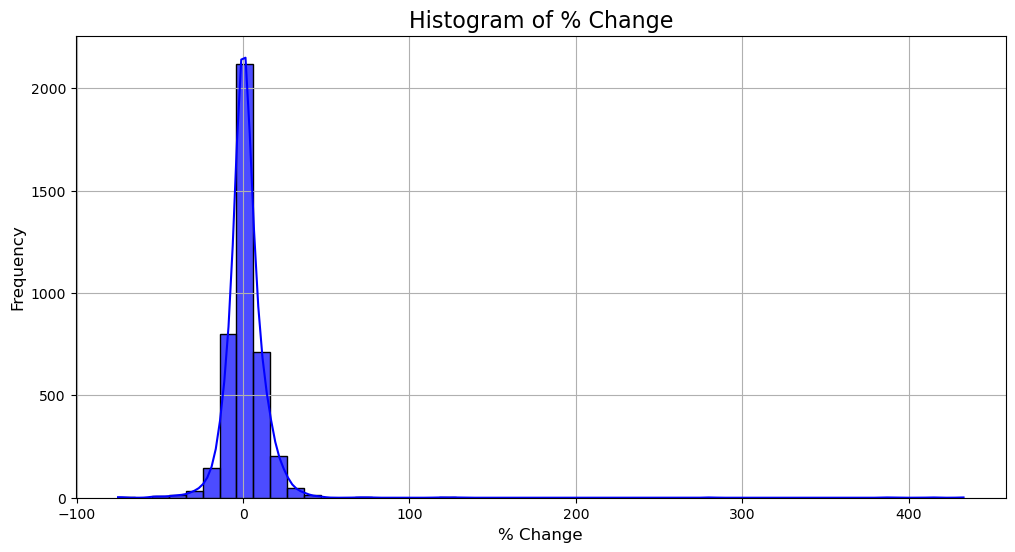

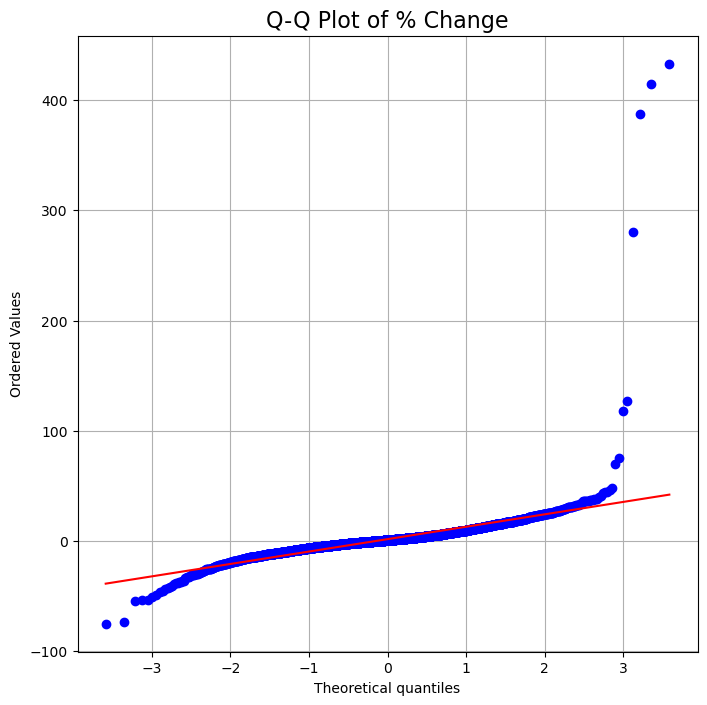

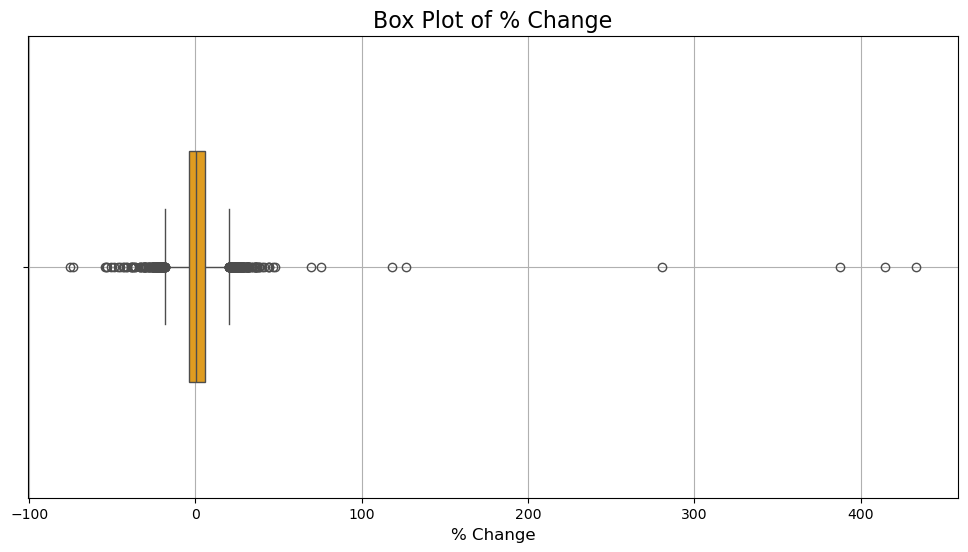

Lower Bound for Outliers: -18.22093825914128
Upper Bound for Outliers: 20.099138460649726
Number of Outliers: 272
Shapiro-Wilk Test Statistic: 0.5009, p-value: 0.0000
The data does not appear to be normally distributed (reject H0).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, probplot

# Drop NaN values from the 'Pct_Change' column
btc_data = btc_data.dropna(subset=['Pct_Change'])

# Histogram to plot the distribution of 'Pct_Change'
plt.figure(figsize=(12, 6))
sns.histplot(btc_data['Pct_Change'], kde=True, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of % Change', fontsize=16)
plt.xlabel('% Change', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

# Q-Q Plot to visually check for normality
plt.figure(figsize=(8, 8))
probplot(btc_data['Pct_Change'], dist="norm", plot=plt)
plt.title('Q-Q Plot of % Change', fontsize=16)
plt.grid(True)
plt.show()

# Box Plot to check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=btc_data['Pct_Change'], color='orange', width=0.5)
plt.title('Box Plot of % Change', fontsize=16)
plt.xlabel('% Change', fontsize=12)
plt.grid(True)
plt.show()

# Identify Outliers based on the IQR (Interquartile Range) method
Q1 = btc_data['Pct_Change'].quantile(0.25)  # First quartile
Q3 = btc_data['Pct_Change'].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR  # Lower bound
upper_bound = Q3 + 1.5 * IQR  # Upper bound

print(f"Lower Bound for Outliers: {lower_bound}")
print(f"Upper Bound for Outliers: {upper_bound}")

# Filter outliers
outliers = btc_data[(btc_data['Pct_Change'] < lower_bound) | (btc_data['Pct_Change'] > upper_bound)]
print(f"Number of Outliers: {len(outliers)}")

# Shapiro-Wilk Test for normality
stat, p_value = shapiro(btc_data['Pct_Change'])
print(f"Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p_value:.4f}")

# Interpretation of the Shapiro-Wilk test result
if p_value > 0.05:
    print("The data appears to be normally distributed (fail to reject H0).")
else:
    print("The data does not appear to be normally distributed (reject H0).")

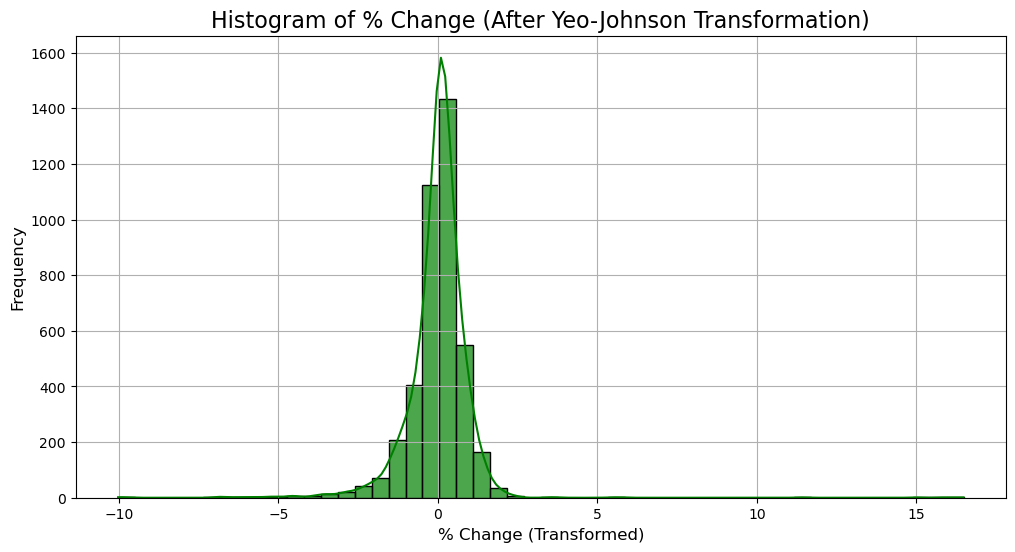

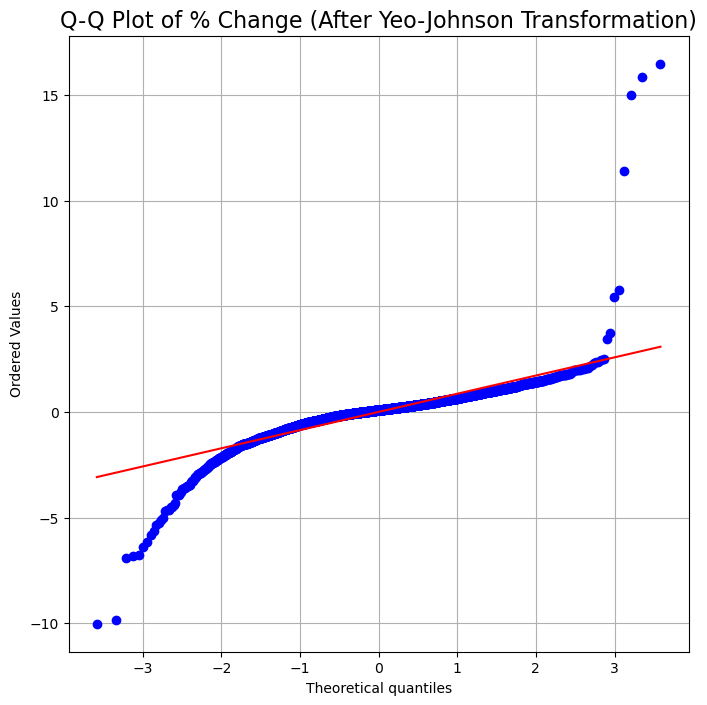

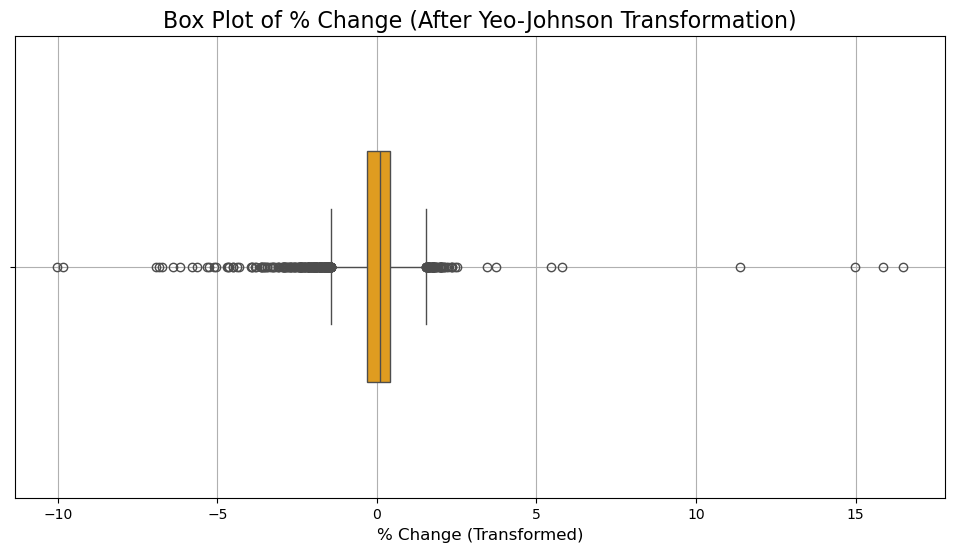

Shapiro-Wilk Test Statistic: 0.7413, p-value: 0.0000
Lower Bound for Outliers (Transformed): -1.428131344460079
Upper Bound for Outliers (Transformed): 1.5346348058134307
Number of Outliers (Transformed Data): 281


In [ ]:
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot, shapiro

# Initialize the Yeo-Johnson transformer
pt = PowerTransformer(method='yeo-johnson')

# Apply the transformation
btc_data['Pct_Change_YJ'] = pt.fit_transform(btc_data[['Pct_Change']])

# Plot the transformed data (Histogram)
plt.figure(figsize=(12, 6))
sns.histplot(btc_data['Pct_Change_YJ'], kde=True, bins=50, color='green', alpha=0.7)
plt.title('Histogram of % Change (After Yeo-Johnson Transformation)', fontsize=16)
plt.xlabel('% Change (Transformed)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

# Q-Q Plot for transformed data
plt.figure(figsize=(8, 8))
probplot(btc_data['Pct_Change_YJ'], dist="norm", plot=plt)
plt.title('Q-Q Plot of % Change (After Yeo-Johnson Transformation)', fontsize=16)
plt.grid(True)
plt.show()

# Box Plot to visualize outliers after transformation
plt.figure(figsize=(12, 6))
sns.boxplot(x=btc_data['Pct_Change_YJ'], color='orange', width=0.5)
plt.title('Box Plot of % Change (After Yeo-Johnson Transformation)', fontsize=16)
plt.xlabel('% Change (Transformed)', fontsize=12)
plt.grid(True)
plt.show()

# Run Shapiro-Wilk test for normality on transformed data
stat, p_value = shapiro(btc_data['Pct_Change_YJ'])
print(f"Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p_value:.4f}")

# Detect Outliers using the IQR method on the transformed data
Q1 = btc_data['Pct_Change_YJ'].quantile(0.25)  # First quartile
Q3 = btc_data['Pct_Change_YJ'].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR  # Lower bound
upper_bound = Q3 + 1.5 * IQR  # Upper bound

# Print the bounds for outliers
print(f"Lower Bound for Outliers (Transformed): {lower_bound}")
print(f"Upper Bound for Outliers (Transformed): {upper_bound}")

# Filter outliers
outliers = btc_data[(btc_data['Pct_Change_YJ'] < lower_bound) | (btc_data['Pct_Change_YJ'] > upper_bound)]
print(f"Number of Outliers (Transformed Data): {len(outliers)}")

# Optionally, cap or remove outliers
# Cap outliers (Winsorization)
btc_data['Pct_Change_YJ_Capped'] = btc_data['Pct_Change_YJ'].clip(lower=lower_bound, upper=upper_bound)

# Remove outliers
btc_data_no_outliers = btc_data[(btc_data['Pct_Change_YJ'] >= lower_bound) & (btc_data['Pct_Change_YJ'] <= upper_bound)]